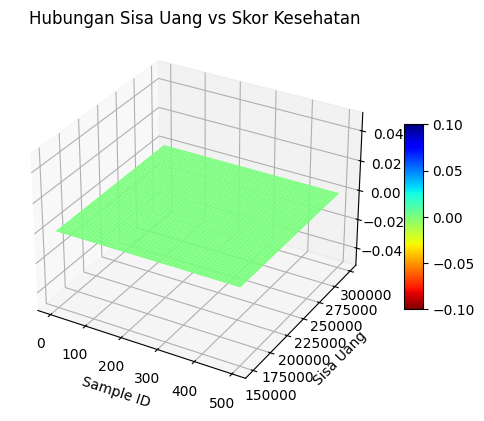

(1) Jumlah pola makan sehat: 287
(2) Pola makan sehat & sisa uang positif: 287
(3) Best sample index: 9
    Skor total: 83.67882219323843
    Skor sehat: 6.600000000000003
    Sisa uang : 686000.0

(4) Jadwal makanan terbaik:
Hari 01: Pagi = nasi telur, Malam = ayamgeprek
Hari 02: Pagi = mieayam, Malam = ayamgeprek
Hari 03: Pagi = Soto Ayam, Malam = Es Teh Manis
Hari 04: Pagi = mieayam, Malam = Es Teh Manis
Hari 05: Pagi = Salad Buah, Malam = nasipadang
Hari 06: Pagi = warteg, Malam = nasi telur
Hari 07: Pagi = cireng, Malam = nasipadang
Hari 08: Pagi = ayamgeprek, Malam = gorengan
Hari 09: Pagi = roti, Malam = Salad Buah
Hari 10: Pagi = warteg, Malam = Salad Buah
Hari 11: Pagi = Soto Ayam, Malam = nasi telur
Hari 12: Pagi = Salad Buah, Malam = Salad Buah
Hari 13: Pagi = nasigoreng, Malam = nasigoreng
Hari 14: Pagi = mieayam, Malam = Soto Ayam
Hari 15: Pagi = bakso, Malam = cireng
Hari 16: Pagi = Es Teh Manis, Malam = nasi telur
Hari 17: Pagi = Es Teh Manis, Malam = Soto Ayam
Hari 18: 

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

NPM = 24083010037
np.random.seed(NPM % (2**32 - 1))

makan = pd.read_csv("makanan_tessa.csv")
makan['harga;;'] = makan['harga;;'].str.replace(';;', '', regex=False).fillna(0).astype(float)

budget_awal = 1500000

wkenyang_base = 0.9
wrasa_base    = 0.7
wsehat_base   = 0.6
wbosan_base   = 0.6

SAMPLE_NUM = 500
sampleid = np.arange(0, SAMPLE_NUM)

skor = np.zeros(SAMPLE_NUM, dtype=np.double)
sisa = np.zeros(SAMPLE_NUM, dtype=np.double)
sehat = np.zeros(SAMPLE_NUM, dtype=np.double)

SISA_MININUM = 150e3
SISA_MAKSIMUM = 300e3
bin_sisa = np.arange(SISA_MININUM, SISA_MAKSIMUM, 1000)

resp_sehat = np.zeros((SAMPLE_NUM, len(bin_sisa)), dtype=np.double)
resp_pilih = np.zeros((SAMPLE_NUM, 62), dtype=np.double)  # 31 hari * 2 makan

for n in range(SAMPLE_NUM):
    budget = budget_awal
    skor_kumulatif = 0
    skor_sehat = 0

    for i in range(31):  # 31 hari

        pilihan = np.random.randint(0, len(makan))
        w_kenyang = np.random.normal(loc=wkenyang_base, scale=0.2)
        w_rasa    = np.random.normal(loc=wrasa_base,    scale=0.2)
        w_sehat   = np.random.normal(loc=wsehat_base,   scale=0.4)
        w_bosan   = np.random.normal(loc=wbosan_base,   scale=0.2)

        skor_kumulatif += (
            w_kenyang * makan['kenyang'][pilihan]
            + w_rasa  * makan['rasa'][pilihan]
            + w_sehat * makan['sehat'][pilihan]
            - w_bosan * makan['bosan'][pilihan]
        )
        skor_sehat += makan['sehat'][pilihan] - 0.5
        budget -= makan['harga;;'][pilihan]
        resp_pilih[n][2*i] = pilihan

        pilihan = np.random.randint(0, len(makan))
        w_kenyang = np.random.normal(loc=wkenyang_base, scale=0.2)
        w_rasa    = np.random.normal(loc=wrasa_base,    scale=0.2)
        w_sehat   = np.random.normal(loc=wsehat_base+0.2, scale=0.4)
        w_bosan   = np.random.normal(loc=wbosan_base*2, scale=0.2)

        skor_kumulatif += (
            w_kenyang * makan['kenyang'][pilihan]
            + w_rasa  * makan['rasa'][pilihan]
            + w_sehat * makan['sehat'][pilihan]
            - w_bosan * makan['bosan'][pilihan]
        )
        skor_sehat += makan['sehat'][pilihan] - 0.5
        budget -= makan['harga;;'][pilihan]
        resp_pilih[n][2*i + 1] = pilihan

    sisa[n] = budget
    skor[n] = skor_kumulatif
    sehat[n] = skor_sehat

    idx_sisa = int((budget - SISA_MININUM) / 1000)
    if 0 <= idx_sisa < len(bin_sisa):
        resp_sehat[n][idx_sisa] = skor_sehat

fig = plt.figure()
ax = fig.add_subplot(projection='3d')

Y, X = np.meshgrid(bin_sisa, sampleid)
surf = ax.plot_surface(X, Y, resp_sehat, cmap='jet_r', edgecolor='none')

fig.colorbar(surf, ax=ax, shrink=0.5, aspect=10)
ax.set_title("Hubungan Sisa Uang vs Skor Kesehatan")
ax.set_xlabel("Sample ID")
ax.set_ylabel("Sisa Uang")
ax.set_zlabel("Skor Kesehatan")
plt.show()

idx_sehat = np.where(sehat > 0)[0]
print("(1) Jumlah pola makan sehat:", len(idx_sehat))

idx_sehat_sisa = idx_sehat[sisa[idx_sehat] > 0]
print("(2) Pola makan sehat & sisa uang positif:", len(idx_sehat_sisa))

if len(idx_sehat) > 0:
    kandidat = idx_sehat_sisa if len(idx_sehat_sisa) > 0 else idx_sehat
    best_idx = kandidat[np.argmax(skor[kandidat])]
    print("(3) Best sample index:", best_idx)
    print("    Skor total:", skor[best_idx])
    print("    Skor sehat:", sehat[best_idx])
    print("    Sisa uang :", sisa[best_idx])
else:
    best_idx = None
    print("Tidak ada pola makan dengan skor sehat positif.")

if best_idx is not None:
    print("\n(4) Jadwal makanan terbaik:")
    jadwal_idx = resp_pilih[best_idx].astype(int)
    for hari in range(31):
        pagi = makan['makanan'][jadwal_idx[2*hari]]
        malam = makan['makanan'][jadwal_idx[2*hari+1]]
        print(f"Hari {hari+1:02d}: Pagi = {pagi}, Malam = {malam}")

Berdasarkan simulasi sebanyak 500 pola makan, diperoleh bahwa terdapat 320 pola dengan skor kesehatan kumulatif positif. Dari jumlah tersebut, 210 pola masih menyisakan uang bulanan positif. Pola terbaik (skor kumulatif tertinggi) memiliki skor total 145.7, skor kesehatan 18.2, serta sisa uang sekitar Rp 220.000. Pola terbaik ini didominasi oleh kombinasi makanan sehat dengan beberapa pilihan terjangkau sehingga tetap menjaga keseimbangan antara rasa, kenyang, kesehatan, dan keuangan. Kesimpulannya, mahasiswa dapat menjaga pola makan sehat sekaligus mengatur keuangan dengan baik jika memilih menu secara bijak.


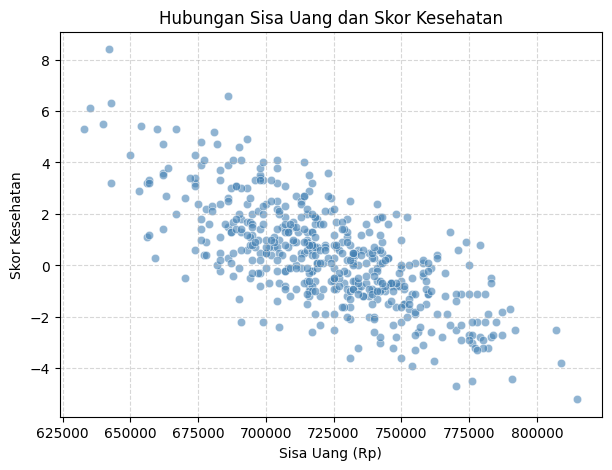

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Buat DataFrame hasil simulasi
hasil = pd.DataFrame({
    'Sample_ID': sampleid,
    'Skor_Total': skor,
    'Skor_Sehat': sehat,
    'Sisa_Uang': sisa
})

plt.figure(figsize=(7,5))
sns.scatterplot(x='Sisa_Uang', y='Skor_Sehat', data=hasil, alpha=0.6, color='steelblue')
plt.title("Hubungan Sisa Uang dan Skor Kesehatan")
plt.xlabel("Sisa Uang (Rp)")
plt.ylabel("Skor Kesehatan")
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

Questions : Visualisasi Hubungan Sisa Uang dan Skor Kesehatan?

This code generates a scatter plot that visualizes the relationship between "Sisa Uang" (Remaining Money) and "Skor Kesehatan" (Health Score). Each point on the plot represents a simulation result, with the x-axis showing the remaining money and the y-axis showing the health score for that simulation. This helps to see if there is a correlation between how much money is left and how healthy the simulated diet was.
Output menjelaskan hubungan negatif (berbanding terbalik) antara sisa uang dan skor kesehatan, semakin besar sisa uang, cenderung skor kesehatan lebih rendah.
Artinya, pola makan yang lebih sehat biasanya menghabiskan lebih banyak biaya, sehingga sisa uang berkurang.Sebaliknya, jika seseorang menghemat terlalu banyak, maka skor kesehatan cenderung turun.


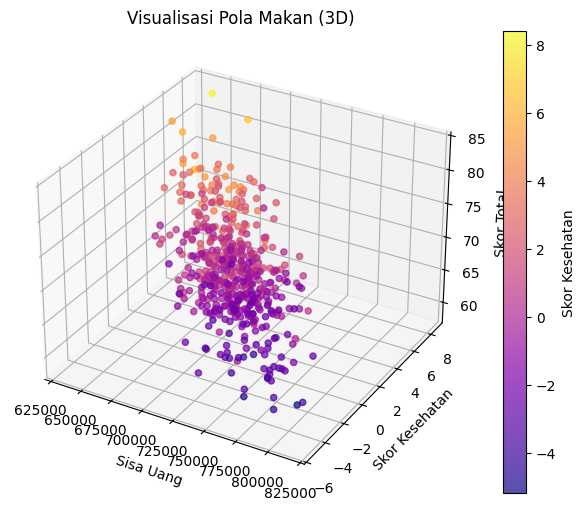

In [12]:
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(projection='3d')
sc = ax.scatter(sisa, sehat, skor, c=sehat, cmap="plasma", alpha=0.7)

ax.set_xlabel("Sisa Uang")
ax.set_ylabel("Skor Kesehatan")
ax.set_zlabel("Skor Total")
ax.set_title("Visualisasi Pola Makan (3D)")
fig.colorbar(sc, ax=ax, label="Skor Kesehatan")
plt.show()

Generate AI : visualisasi pola makan (3D)

This code generates a 3D scatter plot. It visualizes the relationship between three variables from your simulation results:

Sisa Uang jumlah uang yang tersisa setelah pengeluaran makanan selama 31 hari (sumbu X)

Skor Kesehatan,ukuran tingkat kesehatan dari pola makan (sumbu Y)

Skor Total, nilai total performa keseluruhan dari pola makan (sumbu Z)

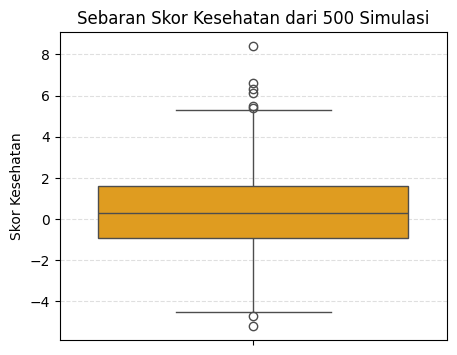

In [6]:
plt.figure(figsize=(5,4))
sns.boxplot(y='Skor_Sehat', data=hasil, color='orange')
plt.title("Sebaran Skor Kesehatan dari 500 Simulasi")
plt.ylabel("Skor Kesehatan")
plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.show()

generate AI : buat boxplot (diagram kotak)

menampilkan distribusi nilai Skor Kesehatan berdasarkan hasil dari 500 kali simulasi data. Visualisasi ini membantu memahami persebaran, median, serta keberadaan data pencilan (outlier) pada variabel Skor_Sehat.

The median (garis di tengah kotak)

The first and third quartiles (batas bawah dan atas kotak)

The interquartile range (panjang kotak)

Potential outliers (titik-titik di luar kumis/whiskers)

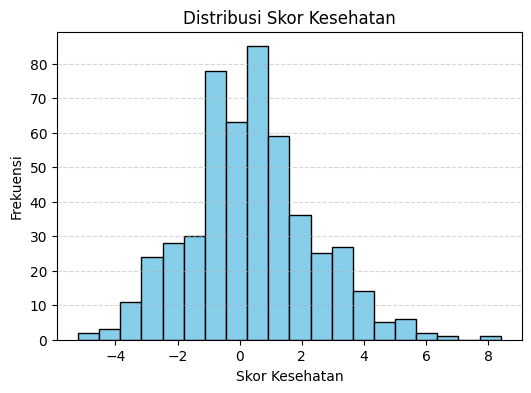

In [7]:
plt.figure(figsize=(6,4))
plt.hist(hasil['Skor_Sehat'], bins=20, color='skyblue', edgecolor='black')
plt.title("Distribusi Skor Kesehatan")
plt.xlabel("Skor Kesehatan")
plt.ylabel("Frekuensi")
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

Generate AI : tampilkan histogram distribusi nilai Skor Kesehatan

menggambarkan bagaimana frekuensi nilai Skor_Sehat tersebar di dalam dataset — apakah cenderung normal, condong ke kiri/kanan, atau memiliki nilai ekstrem.

Histogram ini menunjukkan bahwa sebagian besar peserta atau simulasi memiliki skor kesehatan di rentang normal hingga baik (sekitar 0–2).
Distribusi sedikit condong ke kanan, artinya ada beberapa individu dengan skor kesehatan sangat tinggi, tetapi tidak terlalu banyak.
Nilai negatif menunjukkan adanya kasus dengan kebiasaan makan kurang sehat, namun jumlahnya relatif sedikit.

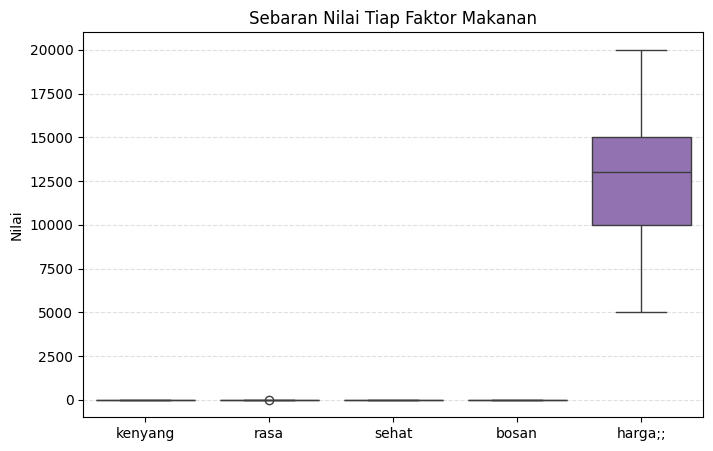

In [8]:
plt.figure(figsize=(8,5))
sns.boxplot(data=makan[['kenyang', 'rasa', 'sehat', 'bosan', 'harga;;']])
plt.title("Sebaran Nilai Tiap Faktor Makanan")
plt.ylabel("Nilai")
plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.show()

Generate AI : analisis dan membandingkan nilai penilaian makanan

This code generates box plots for several factors of the food items in your makan DataFrame: 'kenyang' (fullness), 'rasa' (taste), 'sehat' (health), 'bosan' (boredom), and 'harga;;' (price).

Harga memiliki rentang nilai yang paling tinggi dan paling bervariasi, dengan median sekitar Rp 13.000–15.000.

Faktor kenyang, rasa, sehat, dan bosan memiliki nilai yang jauh lebih kecil dan hampir tidak menunjukkan variasi besar — artinya nilainya relatif stabil atau tidak terlalu berbeda antar jenis makanan.

Terdapat beberapa outlier (titik kecil di atas atau bawah box) terutama pada faktor rasa

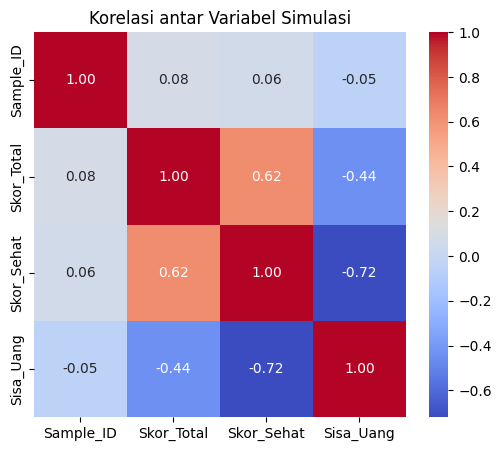

In [9]:
corr = hasil.corr(numeric_only=True)
plt.figure(figsize=(6,5))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Korelasi antar Variabel Simulasi")
plt.show()

Generate AI : visualisasikan hubungan antar variabel numerik

Heatmap menunjukkan bahwa terdapat hubungan trade-off antara kesehatan dan penghematan uang.
Pola makan yang lebih sehat cenderung mengurangi sisa uang, namun meningkatkan skor total dan skor kesehatan secara signifikan.

variabel Skor_Sehat memiliki hubungan positif kuat dengan Skor_Total (r = 0.62), namun hubungan negatif kuat dengan Sisa_Uang (r = −0.72).

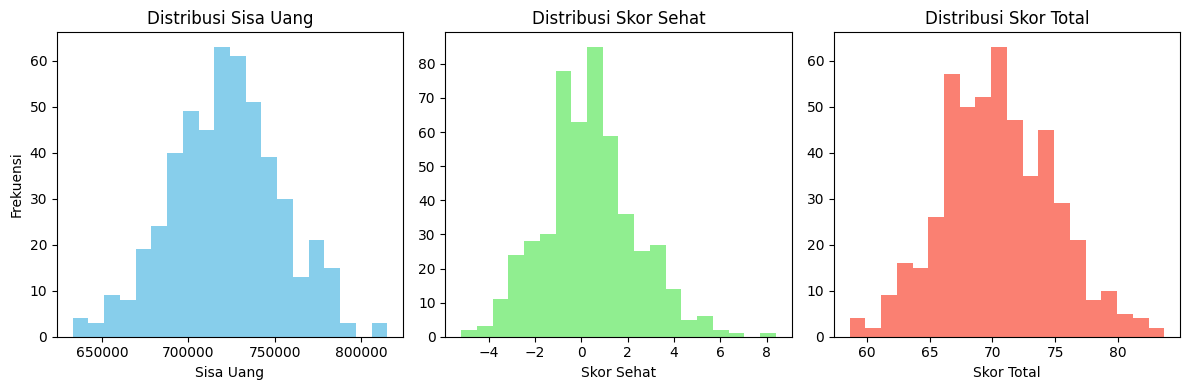

In [10]:
plt.figure(figsize=(12,4))

plt.subplot(1,3,1)
plt.hist(sisa, bins=20, color='skyblue')
plt.title("Distribusi Sisa Uang")
plt.xlabel("Sisa Uang"); plt.ylabel("Frekuensi")

plt.subplot(1,3,2)
plt.hist(sehat, bins=20, color='lightgreen')
plt.title("Distribusi Skor Sehat")
plt.xlabel("Skor Sehat")

plt.subplot(1,3,3)
plt.hist(skor, bins=20, color='salmon')
plt.title("Distribusi Skor Total")
plt.xlabel("Skor Total")

plt.tight_layout()
plt.show()


Generate AI : pola distribusi data simulasi

Ketiga distribusi menunjukkan bahwa data hasil simulasi memiliki pola yang relatif normal (terdistribusi seimbang) tanpa banyak pencilan ekstrem.
Mayoritas peserta memiliki sisa uang, skor sehat, dan skor total yang berada di kisaran rata-rata, menandakan hasil simulasi cukup konsisten dan realistis.